# Predict Netflix User Churn

## Data Preparation

Dataset: https://www.kaggle.com/datasets/vasifasad/netflix-customer-churn-prediction

In [22]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vasifasad/netflix-customer-churn-prediction")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████| 186k/186k [00:00<00:00, 874kB/s]

Extracting files...
Path to dataset files: /Users/minmin/.cache/kagglehub/datasets/vasifasad/netflix-customer-churn-prediction/versions/1


In [23]:
import os

print(os.listdir(path))

['netflix_customer_churn.csv']


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv(os.path.join(path,"netflix_customer_churn.csv"))
df.head(5)

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


### Basic Data Overview

In [28]:
df.dtypes

customer_id                object
age                         int64
gender                     object
subscription_type          object
watch_hours               float64
last_login_days             int64
region                     object
device                     object
monthly_fee               float64
churned                     int64
payment_method             object
number_of_profiles          int64
avg_watch_time_per_day    float64
favorite_genre             object
dtype: object

In [27]:
df.describe()

,age,watch_hours,last_login_days,monthly_fee,churned,number_of_profiles,avg_watch_time_per_day
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,43.847400,11.649450,30.089800,13.683400,0.503000,3.024400,0.874800
std,15.501128,12.014654,17.536078,3.692062,0.500041,1.415841,2.619824
min,18.000000,0.010000,0.000000,8.990000,0.000000,1.000000,0.000000
25%,30.000000,3.337500,15.000000,8.990000,0.000000,2.000000,0.110000
50%,44.000000,8.000000,30.000000,13.990000,1.000000,3.000000,0.290000
75%,58.000000,16.030000,45.000000,17.990000,1.000000,4.000000,0.720000
max,70.000000,110.400000,60.000000,17.990000,1.000000,5.000000,98.420000


#### Outliers in avg_watch_time_per_day
- Because max hours per day is 24, but in the dataset max avg_watch_time_per_day = 98.42.
- Remove all the rows that has avg_watch_time_per_day value exceeds 24.

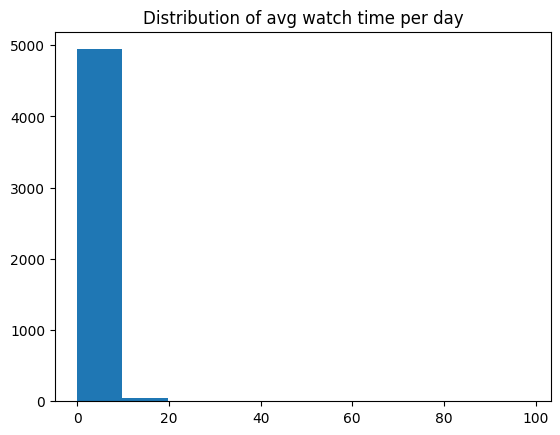

In [36]:
plt.hist(df['avg_watch_time_per_day'])
plt.title('Distribution of avg watch time per day')
plt.show()

In [38]:
df = df[df['avg_watch_time_per_day']<=24]

#### No missing values

In [39]:
df.isnull().sum()

customer_id               0
age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

#### Exclude user_id column 
because it is identifier and doesn’t carry meaningful information for analysis.

In [41]:
df = df.drop('customer_id', axis=1)

### Seperate categorical and numerical variables

In [44]:
categorical = ['gender', 'region', 'subscription_type', 'device', 'monthly_fee', 'payment_method','favorite_genre']

numerical = ['age','watch_hours','last_login_days','number_of_profiles','avg_watch_time_per_day']

print("Numerical features:", numerical)
print("Categorical features:", categorical)

Numerical features: ['age', 'watch_hours', 'last_login_days', 'number_of_profiles', 'avg_watch_time_per_day']
Categorical features: ['gender', 'region', 'subscription_type', 'device', 'monthly_fee', 'payment_method', 'favorite_genre']


In [45]:
for col in categorical:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())


Column: gender
gender
Female    1706
Male      1651
Other     1633
Name: count, dtype: int64

Column: region
region
South America    869
Europe           866
North America    849
Asia             839
Africa           803
Oceania          764
Name: count, dtype: int64

Column: subscription_type
subscription_type
Premium     1690
Basic       1657
Standard    1643
Name: count, dtype: int64

Column: device
device
Tablet     1046
Laptop     1004
Mobile     1003
TV          990
Desktop     947
Name: count, dtype: int64

Column: monthly_fee
monthly_fee
17.99    1690
8.99     1657
13.99    1643
Name: count, dtype: int64

Column: payment_method
payment_method
Debit Card     1026
PayPal         1025
Crypto          993
Gift Card       973
Credit Card     973
Name: count, dtype: int64

Column: favorite_genre
favorite_genre
Drama          730
Documentary    728
Romance        721
Sci-Fi         717
Horror         713
Action         697
Comedy         684
Name: count, dtype: int64


In [51]:
df[['subscription_type', 'monthly_fee']].value_counts()

subscription_type  monthly_fee
Premium            17.99          1690
Basic              8.99           1657
Standard           13.99          1643
Name: count, dtype: int64

### Remove monthly_fee
- monthly_fee and subscription_type deliver the same information. Keep only one of them is enough.
- subscription_type is more intuitive for interpretation, so I choose to keep subscription_type

In [52]:
df = df.drop('monthly_fee', axis=1)

In [60]:
categorical = ['gender', 'region', 'subscription_type', 'device', 'payment_method','favorite_genre']

## Exploratory Data Analysis
- show target distribution
- show numeric distributions
- churn rate by key categorical features
- correlation heatmap for numeric features


### Target Variable Distribution
Pretty balanced dataset

In [55]:
df.churned.mean()

0.5040080160320641

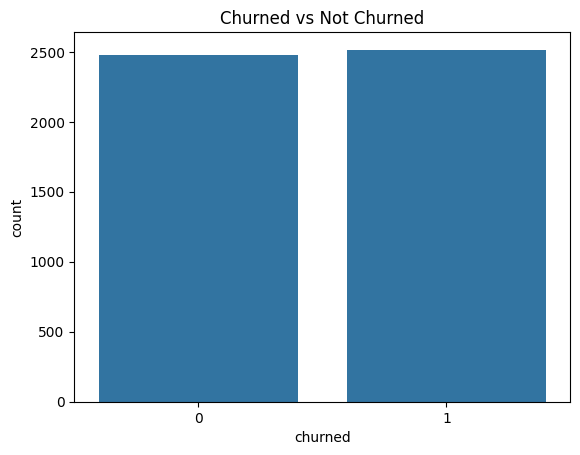

churned
1    50.0
0    50.0
Name: proportion, dtype: float64


In [56]:
sns.countplot(data=df, x='churned')
plt.title("Churned vs Not Churned")
plt.show()

print(df['churned'].value_counts(normalize=True).round(2) * 100)

### Categorical Feature Analysis

#### a. Mutual Information

In [ ]:
from sklearn.metrics import mutual_info_score

In [58]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df.churned)

In [61]:
mi = df[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

subscription_type    0.013533
payment_method       0.009823
favorite_genre       0.000639
region               0.000286
device               0.000143
gender               0.000074
dtype: float64

#### b. Churn Rate by Category

Strong Predictors of Churn:

- Subscription Type: Basic users have the highest churn (≈62%), while Premium users churn the least (≈44%).

- Payment Method: Users paying with Crypto (≈60%) or Gift Cards (≈58%) are more likely to churn, whereas Credit/Debit Card users churn less (≈44%).

In [62]:
for col in categorical:
    churn_rate = df.groupby(col)['churned'].mean().sort_values(ascending=False)
    print(f"\n{col} — Churn Rate by Category:")
    print(churn_rate)


gender — Churn Rate by Category:
gender
Female    0.512309
Male      0.500909
Other     0.498469
Name: churned, dtype: float64

region — Churn Rate by Category:
region
Europe           0.517321
South America    0.516686
Asia             0.507747
Oceania          0.501309
North America    0.495878
Africa           0.483188
Name: churned, dtype: float64

subscription_type — Churn Rate by Category:
subscription_type
Basic       0.619795
Standard    0.455265
Premium     0.437870
Name: churned, dtype: float64

device — Churn Rate by Category:
device
Laptop     0.518924
Mobile     0.505484
TV         0.501010
Tablet     0.500956
Desktop    0.493136
Name: churned, dtype: float64

payment_method — Churn Rate by Category:
payment_method
Crypto         0.598187
Gift Card      0.579651
PayPal         0.471220
Debit Card     0.438596
Credit Card    0.435766
Name: churned, dtype: float64

favorite_genre — Churn Rate by Category:
favorite_genre
Action         0.523673
Drama          0.523288
Horror

#### c. Countplots by Churn

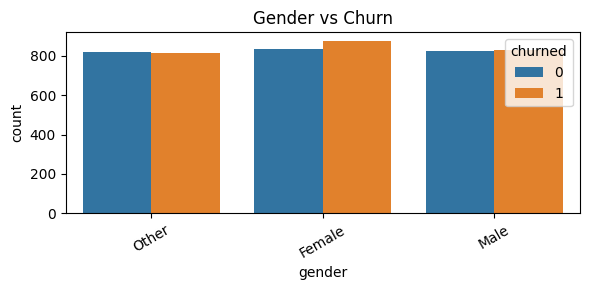

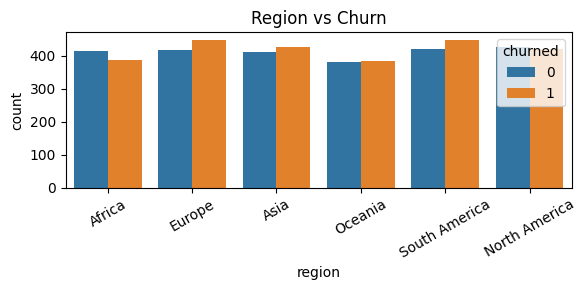

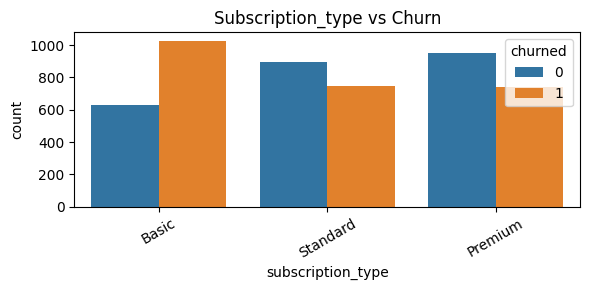

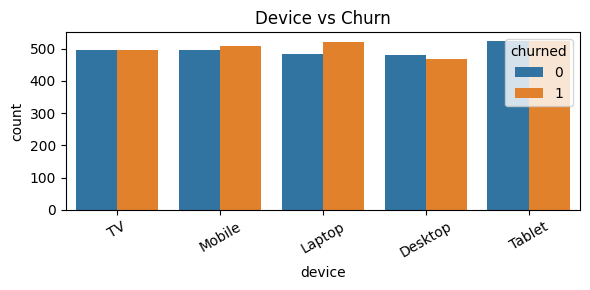

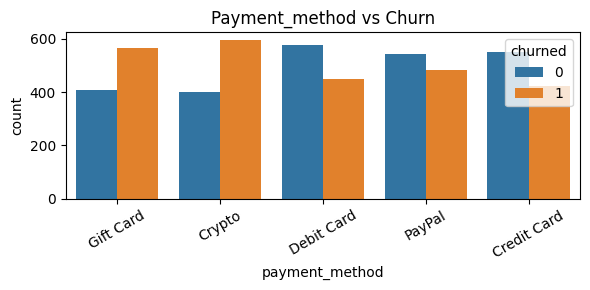

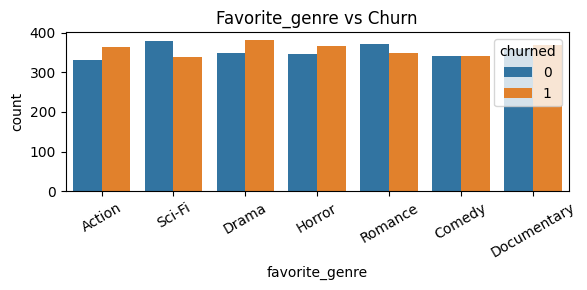

In [63]:
for col in categorical:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df, x=col, hue='churned')
    plt.title(f"{col.capitalize()} vs Churn")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

### Numerical Feature Analysis

#### a. Distribution of Numerical Variables

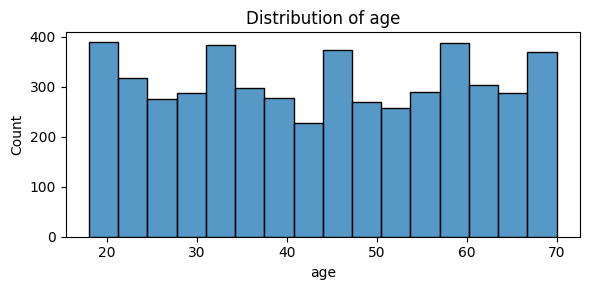

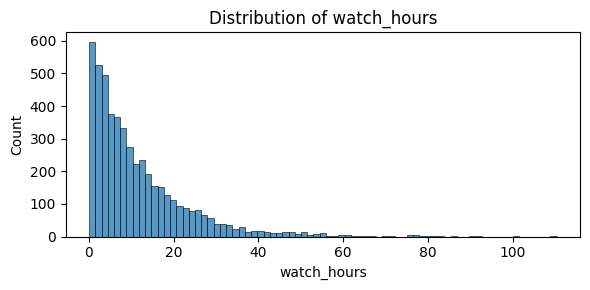

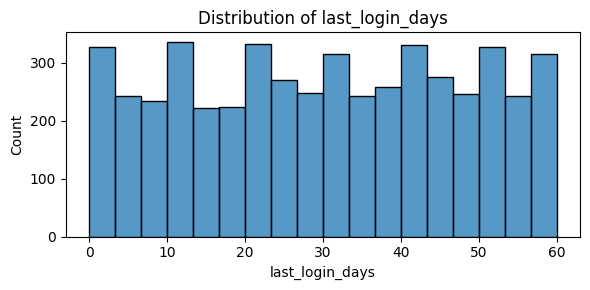

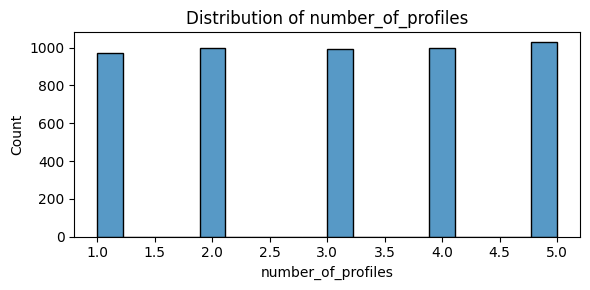

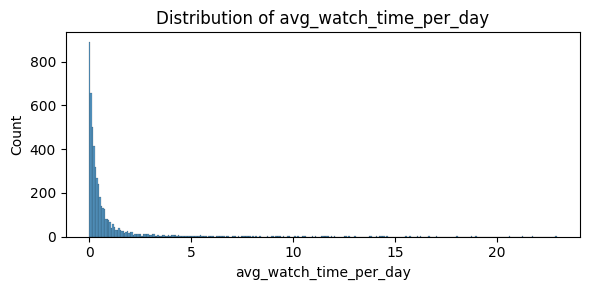

In [70]:
for col in numerical:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col])
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

In [65]:
corr = df[numerical + ['churned']].corr()['churned'].sort_values(ascending=False)
print(corr)

churned                   1.000000
last_login_days           0.469997
age                      -0.003007
number_of_profiles       -0.158429
avg_watch_time_per_day   -0.364919
watch_hours              -0.479886
Name: churned, dtype: float64


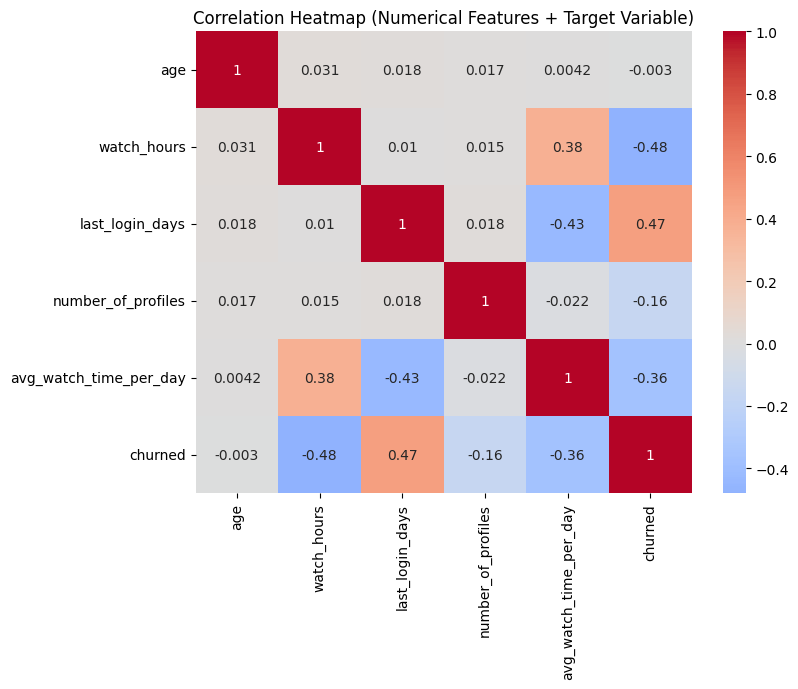

In [66]:
plt.figure(figsize=(8,6))
corr = df[numerical + ['churned']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap (Numerical Features + Target Variable)")
plt.show()


In [71]:
grouped_stats = df.groupby('churned')[numerical].mean().T
display(grouped_stats)

churned,0,1
age,43.886465,43.793241
watch_hours,17.351887,5.918497
last_login_days,21.858586,38.309344
number_of_profiles,3.249697,2.801193
avg_watch_time_per_day,1.443382,0.164048


- Churn is strongly influenced by engagement and activity recency
- While demographic factors like age or account setup (number of profiles) play a smaller role.

#### c. Bin the Age variable into groups

In [77]:
bins = [18, 25, 35, 45, 60, 100]
labels = ['18–25', '26–35', '36–45', '46–60', '60+']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Check distribution
print(df['age_group'].value_counts())

age_group
46–60    1396
60+      1044
26–35     945
36–45     899
18–25     706
Name: count, dtype: int64


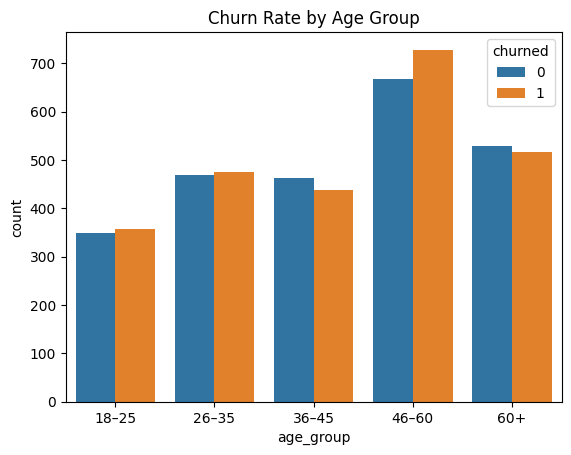

age_group
46–60    0.521490
18–25    0.507082
26–35    0.503704
60+      0.494253
36–45    0.486096
Name: churned, dtype: float64


/var/folders/f3/nvv6pf897x7353zsmv11hxmm0000gn/T/ipykernel_1701/142073596.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_age = df.groupby('age_group')['churned'].mean().sort_values(ascending=False)


In [78]:
sns.countplot(data=df, x='age_group', hue='churned')
plt.title("Churn Rate by Age Group")
plt.show()

churn_by_age = df.groupby('age_group')['churned'].mean().sort_values(ascending=False)
print(churn_by_age)

In [80]:
pd.crosstab(df['age_group'], df['subscription_type'], values=df['churned'], aggfunc='mean').round(3)

subscription_type,Basic,Premium,Standard
age_group,,,
18–25,0.643,0.417,0.472
26–35,0.639,0.437,0.445
36–45,0.569,0.409,0.476
46–60,0.624,0.477,0.456
60+,0.628,0.425,0.435


#### Replace numeric age with categorical age group

Numeric age is weakly correlated (-0.003) with churn, because the effect is nonlinear. By creating age_group bins can capture segements where churn behavior differs and adds interpretability

In [88]:
categorical.append('age_group')
numerical.remove('age')

In [89]:
print("Numerical features:", numerical)
print("Categorical features:", categorical)

Numerical features: ['watch_hours', 'last_login_days', 'number_of_profiles', 'avg_watch_time_per_day']
Categorical features: ['gender', 'region', 'subscription_type', 'device', 'payment_method', 'favorite_genre', 'age_group']


## Split Data

In [91]:
from sklearn.model_selection import train_test_split

In [93]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 10)

In [94]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.2, random_state = 10)

In [95]:
len(df), len(df_train), len(df_val), len(df_test)

(4990, 3193, 799, 998)

In [96]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [98]:
y_train = df_train.churned.values
y_val = df_val.churned.values
y_test = df_test.churned.values

In [101]:
del df_train['churned']
del df_val['churned']
del df_test['churned']

## One-hot Encoding

In [102]:
from sklearn.feature_extraction import DictVectorizer

In [103]:
dv = DictVectorizer(sparse = False)

In [104]:
train_dict = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [105]:
test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

## Model Selection and Parameter Tuning

### Logistic Regression as Baseline Model

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)

In [107]:
lg_model = LogisticRegression(solver='liblinear', C=1.0, class_weight='balanced', max_iter=1000, random_state=10)
lg_model.fit(X_train, y_train)

# Predictions
y_val_pred = lg_model.predict(X_val)
y_val_prob = lg_model.predict_proba(X_val)[:, 1] 


In [110]:
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_prob)
cm = confusion_matrix(y_val, y_val_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))


Accuracy: 0.904881101376721
Precision: 0.8962962962962963
Recall: 0.9143576826196473
F1-score: 0.9052369077306733
ROC-AUC: 0.9708573003997645
Confusion Matrix:
 [[360  42]
 [ 34 363]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       402
           1       0.90      0.91      0.91       397

    accuracy                           0.90       799
   macro avg       0.91      0.90      0.90       799
weighted avg       0.91      0.90      0.90       799



#### Parameter Tuning

In [112]:
C = [0.01, 0.1, 1, 10, 100]

for c in C:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=10)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    
    f1 = f1_score(y_val, y_val_pred)
    roc = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    
    print(f"C={c} | F1={f1:.4f} | ROC-AUC={roc:.4f}")


C=0.01 | F1=0.8767 | ROC-AUC=0.9633
C=0.1 | F1=0.8995 | ROC-AUC=0.9702
C=1 | F1=0.9052 | ROC-AUC=0.9709
C=10 | F1=0.9077 | ROC-AUC=0.9712
C=100 | F1=0.9077 | ROC-AUC=0.9712


- Regularization: Weak regularization (C >= 10) works best for this dataset.

- Model Performance:

- F1 Score ~0.91 → good balance between precision and recall.

- ROC-AUC ~0.97 → strong discriminative ability; model can distinguish churners from non-churners almost perfectly.

In [114]:
coefficients = model.coef_[0]  #
feature_names = dv.get_feature_names_out() 

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df)


                       Feature  Coefficient  Abs_Coefficient
5       avg_watch_time_per_day    -2.961545         2.961545
34     subscription_type=Basic     1.996566         1.996566
26    payment_method=Gift Card     1.341252         1.341252
24       payment_method=Crypto     1.302717         1.302717
22          number_of_profiles    -0.799408         0.799408
25   payment_method=Debit Card    -0.657007         0.657007
18               gender=Female     0.576933         0.576933
36  subscription_type=Standard    -0.501013         0.501013
27       payment_method=PayPal    -0.483472         0.483472
23  payment_method=Credit Card    -0.426282         0.426282
35   subscription_type=Premium    -0.418345         0.418345
8                device=Mobile     0.416803         0.416803
12       favorite_genre=Comedy     0.406595         0.406595
10               device=Tablet     0.341258         0.341258
3              age_group=46–60     0.319879         0.319879
14        favorite_genre

Top Churn-Decreasing Features

- High engagement: avg_watch_time_per_day, watch_hours

- Multiple profiles: number_of_profiles

- Reliable payment methods: payment_method=Debit Card, payment_method=Credit Card

- Higher-tier subscriptions: subscription_type=Standard, subscription_type=Premium

### Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,       
    max_depth=None,          
    min_samples_split=5,     
    min_samples_leaf=3,       
    random_state=10,
    n_jobs=-1               )

rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=10)

In [117]:
y_val_pred = rf.predict(X_val)
y_val_prob = rf.predict_proba(X_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1-score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Accuracy: 0.9662077596996246
F1-score: 0.965865992414665
ROC-AUC: 0.9964472348584533

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       402
           1       0.97      0.96      0.97       397

    accuracy                           0.97       799
   macro avg       0.97      0.97      0.97       799
weighted avg       0.97      0.97      0.97       799



#### Parameter Tuning

In [119]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(random_state=10, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',  # or 'f1'
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC:", grid_search.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   3.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split

### XGBoost

In [120]:
from xgboost import XGBClassifier

In [121]:
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=10,
    use_label_encoder=False,
    eval_metric='logloss',  
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

/Users/minmin/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:35:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, random_state=10, ...)

In [123]:
y_val_pred = xgb_model.predict(X_val)
y_val_prob = xgb_model.predict_proba(X_val)[:,1]

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1-score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Accuracy: 0.9937421777221527
F1-score: 0.9937106918238994
ROC-AUC: 0.9999122774039124
Confusion Matrix:
 [[399   3]
 [  2 395]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       402
           1       0.99      0.99      0.99       397

    accuracy                           0.99       799
   macro avg       0.99      0.99      0.99       799
weighted avg       0.99      0.99      0.99       799



#### Check for overfitting using cross-validation
- With minimal misclassifications, the model is highly discriminative — it nearly perfectly distinguishes churn vs. non-churn users.
- Precision and recall are both strong, meaning the model isn’t biased toward one class.
- Check for overfitting — make sure the results are consistent on a completely unseen test set or via cross-validation.



In [126]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Evaluate using accuracy or F1 (depending on your focus)
scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='f1')

print("F1 scores for each fold:", scores)
print("Mean F1:", np.mean(scores))
print("Std F1:", np.std(scores))


/Users/minmin/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:42:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/minmin/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/minmin/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/minmin/miniconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:42:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

F1 scores for each fold: [0.99688474 0.990625   0.99533437 0.99219969 0.99530516]
Mean F1: 0.994069791529846
Std F1: 0.002298394605513581


- XGBoost model is consistently strong across all subsets of data.
- There’s no indication of overfitting or instability.

## Model Comparison and Selection

| Model                   | F1-score | ROC-AUC   | Key Insight                                                              |
| ----------------------- | -------- | --------- | ------------------------------------------------------------------------ |
| **Logistic Regression** | 0.905    | 0.971     | Strong baseline, captures linear relationships effectively.              |
| **Random Forest**       | 0.994    | 0.998     | Excellent accuracy, robust generalization, minimal overfitting.          |
| **XGBoost**             | 0.994    | **0.999** | Best overall performance and stability (validated via cross-validation). |


## Export & Load model (XGBoost)

In [127]:
import pickle

In [128]:
with open("xgb_churn_pipeline.pkl", "wb") as file:
    pickle.dump({
        "vectorizer": dv,      
        "model": xgb_model
    }, file)

print("Full XGBoost churn pipeline saved successfully!")

Full XGBoost churn pipeline saved successfully!


In [129]:
with open("xgb_churn_pipeline.pkl", "rb") as file:
    pipeline = pickle.load(file)

dv = pipeline["vectorizer"]
model = pipeline["model"]

# Example: make prediction on new customer data
sample = {
    "age": 34,
    "gender": "Female",
    "subscription_type": "Standard",
    "watch_hours": 15.3,
    "last_login_days": 5,
    "region": "Europe",
    "device": "Mobile",
    "monthly_fee": 13.99,
    "payment_method": "PayPal",
    "number_of_profiles": 3,
    "avg_watch_time_per_day": 1.2,
    "favorite_genre": "Drama"
}

X_new = dv.transform([sample])
y_pred = model.predict(X_new)

print("Predicted churn:", y_pred[0])

Predicted churn: 0
